In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

from scipy import ndimage 
import time 

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

Paths defined in paths module:
 paths.data_root: /Users/trafferty/data
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.projects_root: /Users/trafferty/data/projects
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.dat_root: /Users/trafferty/data/dat
 paths.tmp_dir: /Users/trafferty/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.mii_home: /Users/trafferty/dev
 paths.inhouse: /Users/trafferty/dev/src/inhouse


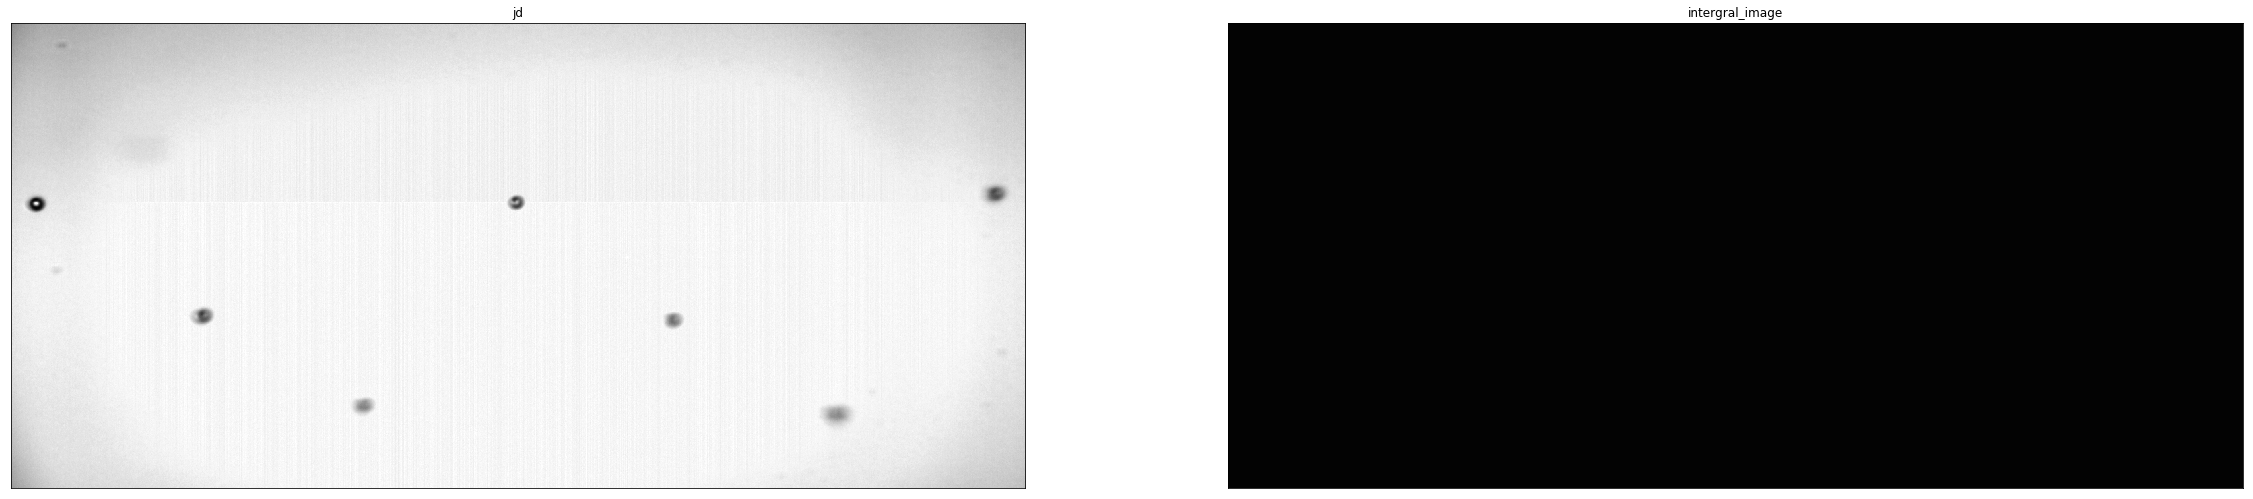

In [12]:
jd = cv2.imread('/Users/trafferty/tmp/DIF/just_drops.png', cv2.IMREAD_GRAYSCALE)

jd = jd.astype(np.float)
intergral_image = cv2.dft( jd )
intergral_image
# if you dont want the top row/left column pad
#intergral_image = intergral_image[1:,1:]


util.plot_imgs([( jd, "jd"), ( intergral_image, "intergral_image")], fig_size=20)

In [ ]:
void adaptiveThreshold(const cv::Mat img, cv::Mat& img_binary, double thresh)
{
    long sum=0;
    int count=0;
    int index;
    int x1, y1, x2, y2;

    unsigned char* input = img.data;
    unsigned char* bin = img_binary.data;

    int width = img.cols;
    int height = img.rows;
    int s2 = (width/8)/2;

    int foreground_value = 255;
    switch ( img.type() ) {
      case CV_8U:  foreground_value = 255; break;
      case CV_8S:  foreground_value = 128; break;
      case CV_16U: foreground_value = 65536; break;
      case CV_16S: foreground_value = 32768; break;
    }

    // create the integral image
    std::vector<unsigned long> integralImg((width*height), 0);

    for (int i=0; i<width; i++)
    {
        // reset this column sum
        sum = 0;

        for (int j=0; j<height; j++)
        {
            index = j*width+i;

            sum += input[index];
            if (i==0)
                integralImg[index] = sum;
            else
                integralImg[index] = integralImg[index-1] + sum;
        }
    }

    // perform thresholding
    for (int i=0; i<width; i++)
    {
        for (int j=0; j<height; j++)
        {
            index = j*width+i;

            // set the SxS region
            x1=i-s2; x2=i+s2;
            y1=j-s2; y2=j+s2;

            // check the border
            if (x1 < 0) x1 = 0;
            if (x2 >= width) x2 = width-1;
            if (y1 < 0) y1 = 0;
            if (y2 >= height) y2 = height-1;
            
            count = (x2-x1)*(y2-y1);

            // I(x,y)=s(x2,y2)-s(x1,y2)-s(x2,y1)+s(x1,x1)
            sum = integralImg[y2*width+x2] -
                  integralImg[y1*width+x2] -
                  integralImg[y2*width+x1] +
                  integralImg[y1*width+x1];

            if ((long)(input[index]*count) < (long)(sum*(1.0-thresh)))
                bin[index] = 0;
            else
                bin[index] = foreground_value;
        }
    }
}


In [47]:
def adaptive_thresh_orig(input_img):
    h, w = input_img.shape

    S = w/8
    s2 = S/2
    T = 15.0

    #integral img
    int_img = np.zeros_like(input_img, dtype=np.uint32)
    for col in range(w):
        for row in range(h):
            int_img[row,col] = input_img[0:row,0:col].sum()

    #output img
    out_img = np.zeros_like(input_img)    
    for col in range(w):
        for row in range(h):
            #SxS region
            y0 = max(row-s2, 0)
            y1 = min(row+s2, h-1)
            x0 = max(col-s2, 0)
            x1 = min(col+s2, w-1)

            count = (y1-y0)*(x1-x0)

            sum_ = int_img[y1, x1]-int_img[y0, x1]-int_img[y1, x0]+int_img[y0, x0]

            if input_img[row, col]*count < sum_*(100.-T)/100.:
                out_img[row,col] = 0
            else:
                out_img[row,col] = 255

    return out_img


In [44]:
def adaptive_thresh(input_img):

    '''
    int width = img.cols;
    int height = img.rows;
    int s2 = (width/8)/2;
    '''
    h, w = input_img.shape

    s2 = int(int(w/8)/2)
    thresh = 0.35
    
    foreground_value = 255
    if input_img.dtype == 'uint16':
        foreground_value = 32768

    '''
    for (int i=0; i<width; i++)
    {
        // reset this column sum
        sum = 0;

        for (int j=0; j<height; j++)
        {
            index = j*width+i;

            sum += input[index];
            if (i==0)
                integralImg[index] = sum;
            else
                integralImg[index] = integralImg[index-1] + sum;
        }
    }
    '''
    #integral img
#orig 2D:    
#    int_img = np.zeros_like(input_img, dtype=np.int64)
#1D:    
    int_img = np.zeros((w*h), dtype=np.int64)

#orig:
#     for col in range(w):
#         for row in range(h):
#             int_img[row,col] = input_img[0:row,0:col].sum()

#for 2D int_img
#     for col in range(w):
#         sum = 0
#         for row in range(h):
#             sum += input_img[row,col]
#             if col == 0:
#                 int_img[row,col] = sum
#             else:
#                 int_img[row,col] = int_img[row,col] + sum
#for 1D int_img
    for col in range(w):
        sum = 0
        for row in range(h):
            sum += input_img[row,col]
            if col == 0:
                int_img[row,col] = sum
            else:
                int_img[row,col] = int_img[row,col] + sum

    #output img
    out_img = np.zeros_like(input_img)    
    
#     for (int i=0; i<width; i++)
#     {
#         for (int j=0; j<height; j++)
#         {
#             index = j*width+i;

#             // set the SxS region
#             x1=i-s2; x2=i+s2;
#             y1=j-s2; y2=j+s2;

#             // check the border
#             if (x1 < 0) x1 = 0;
#             if (x2 >= width) x2 = width-1;
#             if (y1 < 0) y1 = 0;
#             if (y2 >= height) y2 = height-1;
            
#             count = (x2-x1)*(y2-y1);

#             // I(x,y)=s(x2,y2)-s(x1,y2)-s(x2,y1)+s(x1,x1)
#             sum = integralImg[y2*width+x2] -
#                   integralImg[y1*width+x2] -
#                   integralImg[y2*width+x1] +
#                   integralImg[y1*width+x1];

#             if ((long)(input[index]*count) < (long)(sum*(1.0-thresh)))
#                 bin[index] = 0;
#             else
#                 bin[index] = foreground_value;
#         }
#     }

    bg_cnt = 0
    fg_cnt = 0 

    for i in range(w):
        for j in range(h):
            
            index = j*w+i;
            
            #SxS region
            x1=i-s2
            x2=i+s2
            y1=j-s2
            y2=j+s2

            # check the border
            if x1 < 0: x1 = 0
            if x2 >= w: x2 = w-1
            if y1 < 0: y1 = 0
            if y2 >= h: y2 = h-1

            count = (x2-x1)*(y2-y1)
            
#             print(x1)
#             print(x2)
#             print(y1)
#             print(y2)
            try:
                sum_ = int_img[y2, x2] - int_img[y1, x2] - int_img[y2, x1] + int_img[y1, x1]
#                 if (int_img[y2, x2] - int_img[y1, x2] - int_img[y2, x1] + int_img[y1, x1]) < 0:
#                     sum_ = 0
#                 else:
#                     sum_ = int_img[y2, x2] - int_img[y1, x2] - int_img[y2, x1] + int_img[y1, x1]
            except:
                print(x1)
                print(x2)
                print(y1)
                print(y2)
                print('------------')
                print(int_img[y2, x2])
                print(int_img[y1, x2])
                print(int_img[y2, x1])
                print(int_img[y1, x1])
                raise()

            if (input_img[row, col]*count) < (sum_*(1.0-thresh)):
                out_img[row,col] = 0
                bg_cnt += 1
            else:
                out_img[row,col] = foreground_value
                fg_cnt += 1
                
                
                
    print(f"bg_cnt = {bg_cnt}, fg_cnt = {fg_cnt}")    
                
    return out_img


In [89]:
def bradley_roth_numpy(image, s=None, t=None): 

    # Convert image to numpy array 
    img = np.array(image).astype(np.float) 

    # Default window size is round(cols/8) 
    if s is None: 
         s = np.round(img.shape[1]/8) 

    # Default threshold is 15% of the total 
    # area in the window 
    if t is None: 
         t = 20.0 

    # Compute integral image 
    intImage = np.cumsum(np.cumsum(img, axis=1), axis=0) 

    # Define grid of points 
    (rows,cols) = img.shape[:2] 
    (X,Y) = np.meshgrid(np.arange(cols), np.arange(rows)) 

    # Make into 1D grid of coordinates for easier access 
    X = X.ravel() 
    Y = Y.ravel() 

    # Ensure s is even so that we are able to index into the image 
    # properly 
    s = s + np.mod(s,2) 

    # Access the four corners of each neighbourhood 
    x1 = X - s/2 
    x2 = X + s/2 
    y1 = Y - s/2 
    y2 = Y + s/2 

    # Ensure no coordinates are out of bounds 
    x1[x1 < 0] = 0 
    x2[x2 >= cols] = cols-1 
    y1[y1 < 0] = 0 
    y2[y2 >= rows] = rows-1 

    # Count how many pixels are in each neighbourhood 
    count = (x2 - x1) * (y2 - y1) 

    # Compute the row and column coordinates to access 
    # each corner of the neighbourhood for the integral image 
    f1_x = x2.astype(np.uint8)
    f1_y = y2.astype(np.uint8) 
    f2_x = x2.astype(np.uint8) 
    f2_y = (y1 - 1).astype(np.uint8) 
    f2_y[f2_y < 0] = 0 
    f3_x = (x1-1).astype(np.uint8) 
    f3_x[f3_x < 0] = 0 
    f3_y = y2.astype(np.uint8) 
    f4_x = f3_x.astype(np.uint8) 
    f4_y = f2_y.astype(np.uint8) 

    try:
        # Compute areas of each window 
        sums = intImage[f1_y, f1_x] - intImage[f2_y, f2_x] - intImage[f3_y, f3_x] + intImage[f4_y, f4_x] 
    except:
        print(f1_x)
        print(f1_y)
        print(f2_x)
        print(f2_y) 
        print(f3_x)
        print(f3_y)
        print(f4_x)
        print(f4_y)
        raise()    
        
        
    # Compute thresholded image and reshape into a 2D grid 
    out = np.ones(rows*cols, dtype=np.bool) 
    out[img.ravel()*count <= sums*(100.0 - t)/100.0] = False 

    # Also convert back to uint8 
    out = 255*np.reshape(out, (rows, cols)).astype(np.uint8) 

    # Return PIL image back to user 
    #return Image.fromarray(out) 
    return out


In [102]:
def faster_bradley_threshold(image, threshold=75, window_r=5): 
    percentage = threshold/100. 
    window_diam = 2*window_r + 1 
    
    # convert image to numpy array of grayscale values 
    img = image.astype(np.float) 

    # matrix of local means with scipy (this replaces integral image)
    means = ndimage.uniform_filter(img, window_diam) 
    
    # result: 0 for entry less than percentage*mean, 255 otherwise 
    height, width = img.shape[:2] 
    result = np.zeros((height,width), np.uint8) # initially all 0 
    result[img >= percentage * means] = 255  # numpy magic :) 

    return result

def bradley_threshold(image, threshold=75, windowsize=5): 
    ws = windowsize 
    ##image2 = copy.copy(image).convert('L')
    image2 = np.array(image.copy()).astype(np.float) 
    
    ##w, h = image.size 
    (h,w) = image2.shape[:2] 

    l = image.convert('L').load() 
    l2 = image2.load() 
    threshold /= 100.0 
    for y in range(h): 
        for x in range(w): 
            #find neighboring pixels 
            neighbors =[(x+x2,y+y2) for x2 in range(-ws,ws) for y2 in range(-ws, ws) if x+x2>0 and x+x2<w and y+y2>0 and y+y2<h] 
            #mean of all neighboring pixels 
            mean = sum([l[a,b] for a,b in neighbors])/len(neighbors) 
            if l[x, y] < threshold*mean: 
                l2[x,y] = 0 
            else: 
                l2[x,y] = 255 
    return image2 


uint8


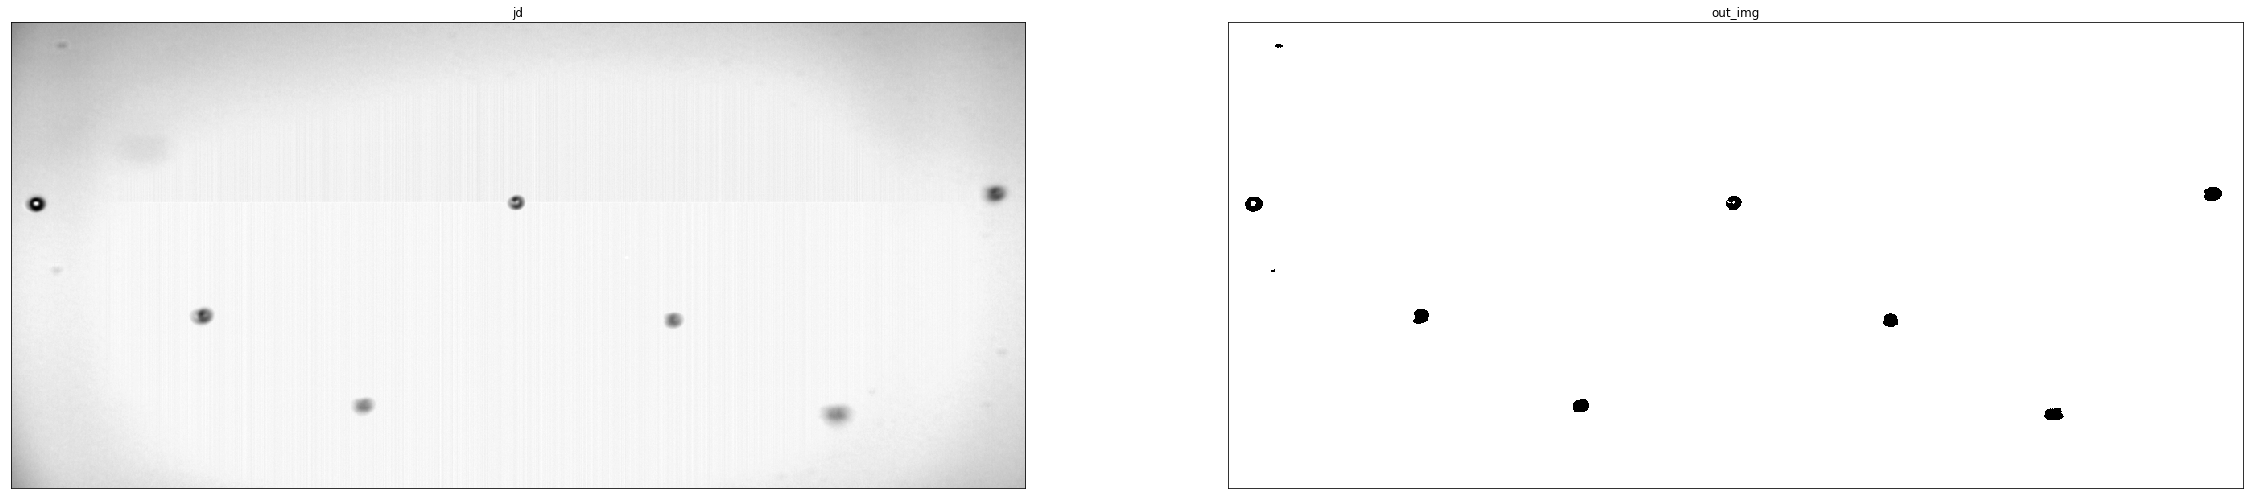

In [110]:
np.seterr(all='warn')

f = '/Users/trafferty/tmp/DIF/just_drops_1261x579.png'
# f = '/Users/trafferty/tmp/DIF/just_drops_DIF2_1262x631.png'
# f = '/Users/trafferty/tmp/DIF/just_drops_DIF2_1262x631_8bit.png'

jd = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
print(jd.dtype)
#out_img = adaptive_thresh_orig(jd)
#out_img = bradley_roth_numpy(jd)
out_img = faster_bradley_threshold(jd, threshold=95, window_r=10)
#out_img = bradley_threshold(jd)

util.plot_imgs([( jd, "jd"), ( out_img, "out_img")], fig_size=20)
# fig, axes = plt.subplots(nrows= 1, ncols=2, squeeze=True, figsize=(30,(5*1)))
# ax1 = axes[0]
# ax2 = axes[1]
# ax1.imshow(jd, cmap='gray',interpolation='nearest', aspect='equal')
# ax1.axis('off')
# ax1.set_title("jd")
# ax2.imshow(out_img, cmap='gray',interpolation='nearest', aspect='equal')
# ax2.axis('off')
# ax2.set_title("out_img")


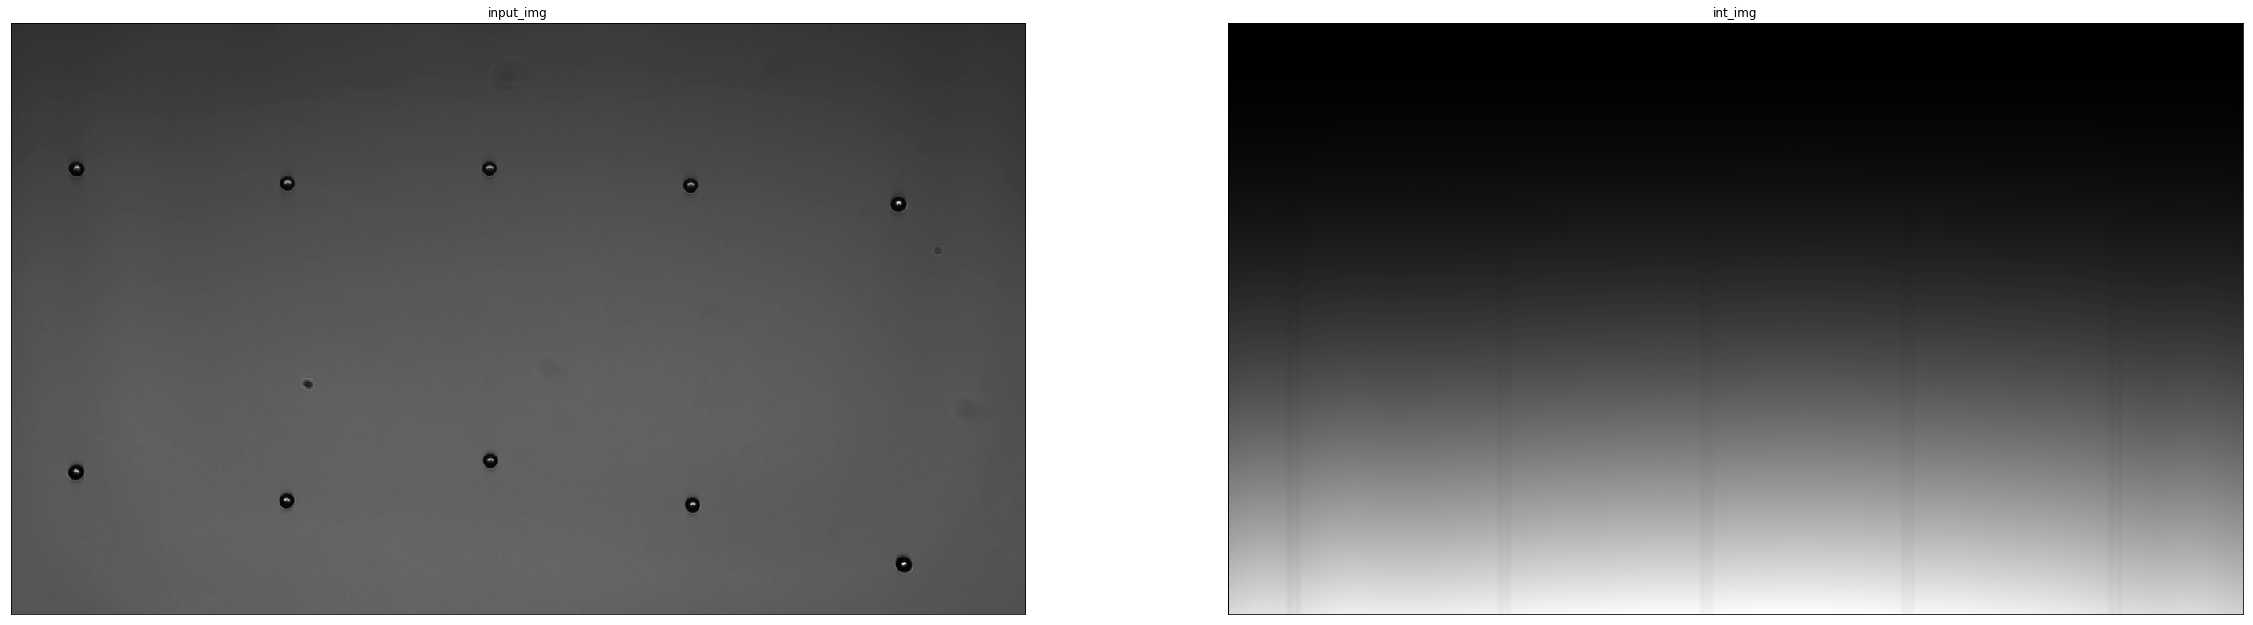

In [19]:
input_img = cv2.imread('/Users/trafferty/tmp/DIF/just_drops_DIF2_1262x631_8bit.png', cv2.IMREAD_GRAYSCALE)
h, w = input_img.shape

'''
for (int i=0; i<width; i++)
{
    // reset this column sum
    sum = 0;

    for (int j=0; j<height; j++)
    {
        index = j*width+i;

        sum += input[index];
        if (i==0)
            integralImg[index] = sum;
        else
            integralImg[index] = integralImg[index-1] + sum;
    }
}
'''

int_img = np.zeros_like(input_img, dtype=np.uint32)
for col in range(w):
    sum = 0
    for row in range(h):
        sum += input_img[row,col]
        if col == 0:
            int_img[row,col] = sum
        else:
            int_img[row,col] = int_img[row-1,col] + sum

util.plot_imgs([( input_img, "input_img"), ( int_img, "int_img")], fig_size=20)

In [ ]:
from scipy import ndimage 
